# Стохастический градиентный спуск

Сохраните ваше решение в формате Name_Surname.ipynb, например Ivan_Ivanov.ipynb

Credits: [Евгений Соколов](https://github.com/esokolov)

### О задании

Задание состоит из двух частей: в **первой** части вы научитесь применять готовые модели из `sklearn` на данных и исследуете особенности разных видов регуляризации; во **второй** части вы реализуете собственный класс линейной регрессии для нестандартной функции потерь (включая процесс обучения) и исследуете скорость сходимости различных градиентных методов для этой модели.

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from matplotlib import pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score

In [2]:
df=pd.read_csv('SGD_data.txt')

In [3]:
df.head()

,f0,f1,f2,f3,f4,f5,f6
0,16.99,1.01,0.976270,-3.697815,0.623295,0.524760,7199.992000
1,10.34,1.66,4.303787,7.715073,0.886961,0.473862,2466.136700
2,21.01,3.50,2.055268,-6.464284,0.618826,1.657394,2969.369100
3,23.68,3.31,0.897664,1.335254,0.133461,1.234554,1040.665300
4,24.59,3.61,-1.526904,-0.196414,0.980580,3.086397,37.469975


## Линейная регрессия из коробки

#### 1.  Разбейте выборку, загруженную в ячейке выше в переменную `df`, на обучающую и тестовую части в соотношении 8:2.

In [4]:
Y = df['f1'].to_list().copy()
X = df.drop(columns=['f1'])

In [5]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, shuffle=True)

#### 2. В качестве целевой переменной для задачи регрессии будем использовать значения признака f1. Обучите, а затем провалидируйте на тестовых данных  следующие модели, используя в качестве метрики качества $R^2$:
* [`LinearRegression`](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html);
* [`Lasso`](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html) (линейная регрессия с $L1$-регуляризатором) с коэффициентом регуляризации, равным 0.01.

Не забудьте отмасштабировать данные перед обучением моделей!

In [6]:
scaler = StandardScaler()
norm_x_train = scaler.fit_transform(X_train)
norm_x_test = scaler.transform(X_test)

In [7]:
linear_cls = LinearRegression().fit(norm_x_train, Y_train)
linear_cls.score(norm_x_test, Y_test)

0.3582084464005657

In [8]:
l1_reg = Lasso(alpha=0.01).fit(norm_x_train, Y_train)
l1_reg.score(norm_x_test, Y_test)

0.36403856209887886

#### 3. Изучите значения параметров получившихся моделей и сравните количество строго нулевых весов в них.

In [9]:
print(f'LinearRegression params:\n{linear_cls.get_params()}')
print(f'Lasso params:\n{l1_reg.get_params()}')

LinearRegression params:
{'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'normalize': False}
Lasso params:
{'alpha': 0.01, 'copy_X': True, 'fit_intercept': True, 'max_iter': 1000, 'normalize': False, 'positive': False, 'precompute': False, 'random_state': None, 'selection': 'cyclic', 'tol': 0.0001, 'warm_start': False}


In [10]:
non_zero_lin = len(linear_cls.coef_) - np.count_nonzero(linear_cls.coef_)
print(f'LinearRegression zero: {non_zero_lin}')
non_zero_l1 = len(l1_reg.coef_) - np.count_nonzero(l1_reg.coef_)
print(f'Lasso zero: {non_zero_l1}')

LinearRegression zero: 0
Lasso zero: 1


In [11]:
linear_cls.coef_

array([0.94770153, 0.03323886, 0.00814933, 0.05699294, 0.16284955,
       0.03344471])

In [12]:
l1_reg.coef_

array([0.94008833, 0.02468038, 0.        , 0.04722443, 0.15434218,
       0.02537601])

#### 4. Нарисуйте попарные scatter plot для всех признаков в исходных данных (включая f1). Можно ли что-то сказать о связи признаков, веса которых были занулены методом Lasso, с целевой переменной?

In [13]:
def pairplot(df, target, colour):
    for i, feature in enumerate(df.columns):
        if feature != target:
            plt.scatter(df[feature], df[target], color=colour)
            plt.xlabel(feature)
            plt.ylabel(target)
            plt.show()

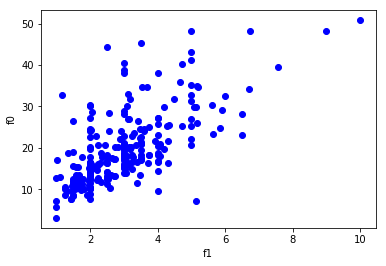

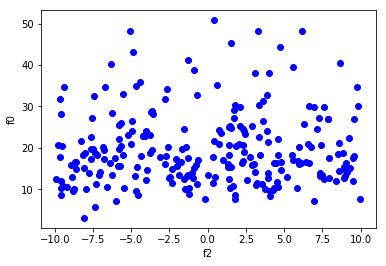

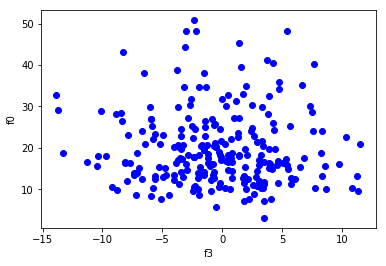

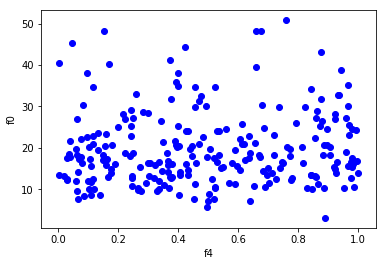

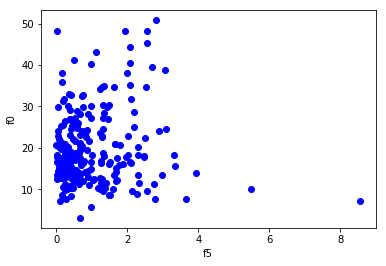

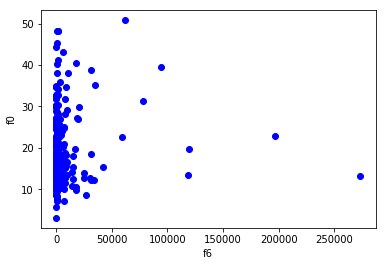

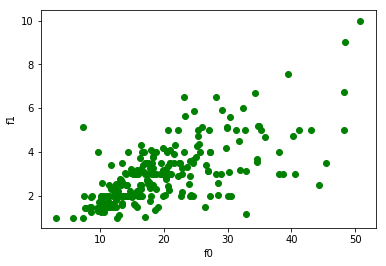

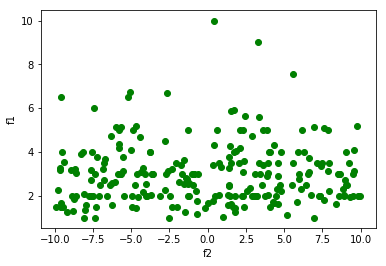

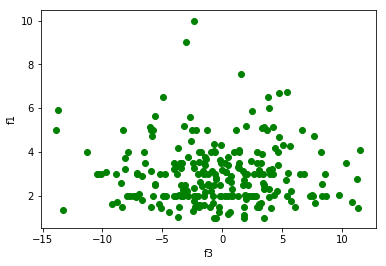

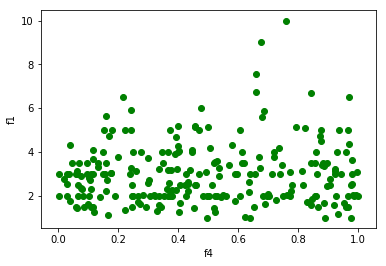

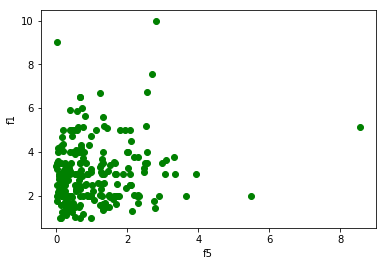

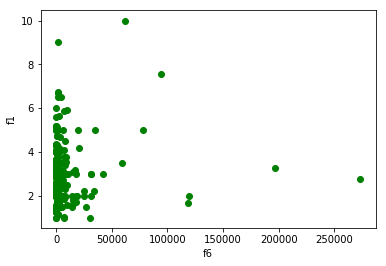

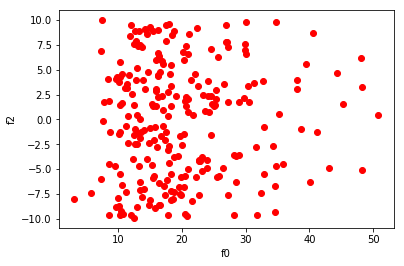

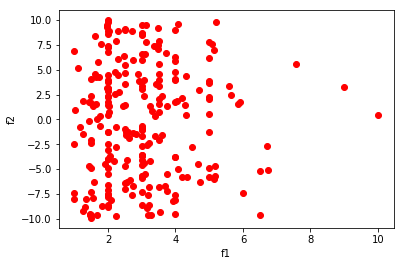

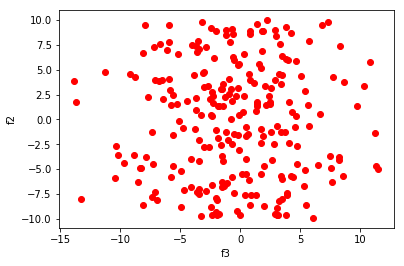

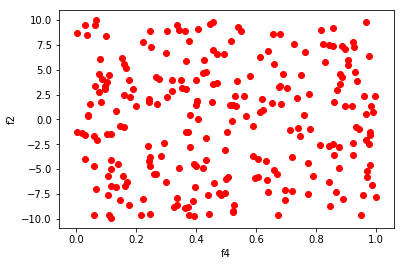

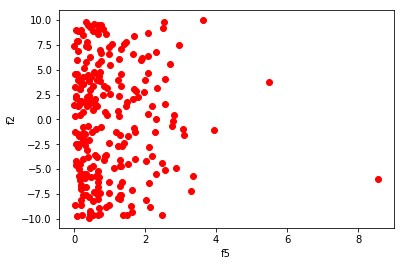

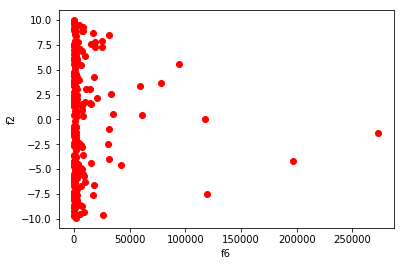

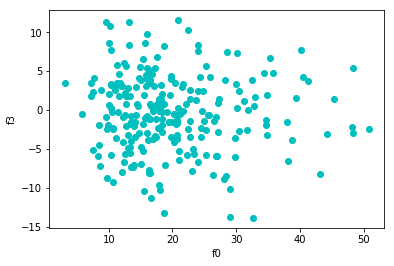

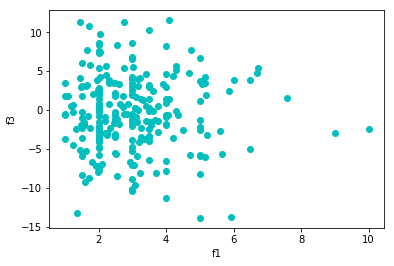

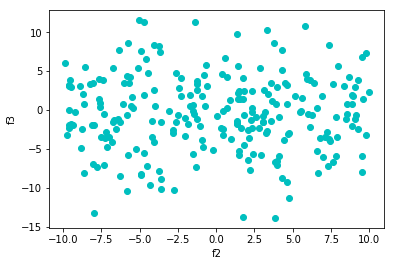

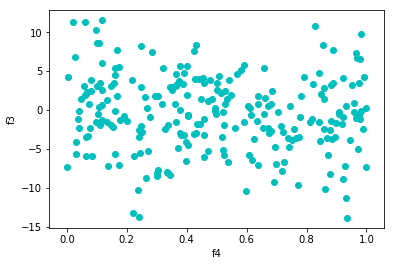

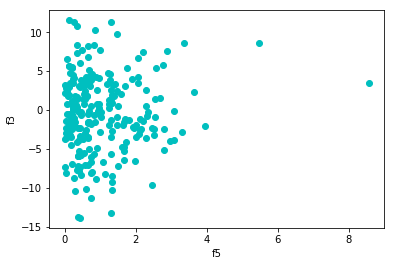

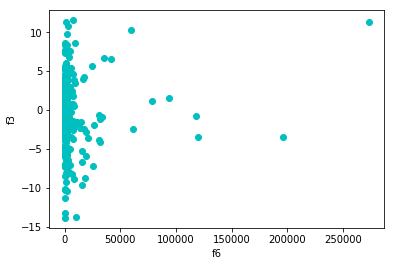

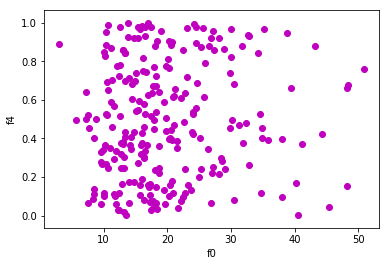

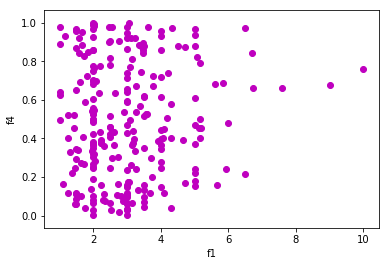

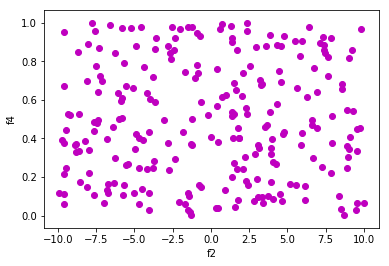

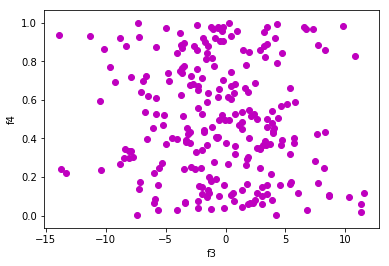

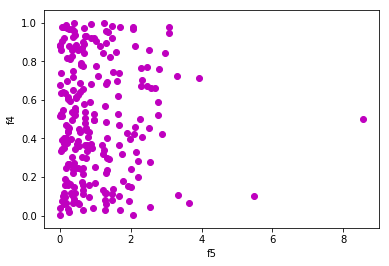

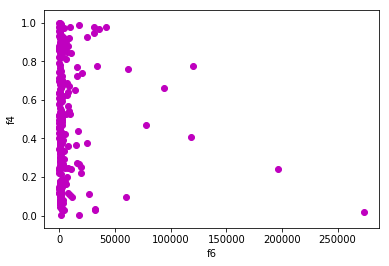

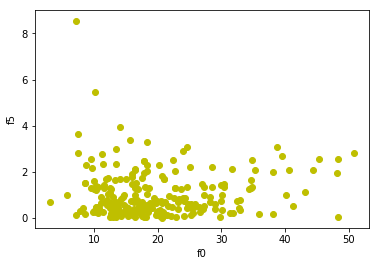

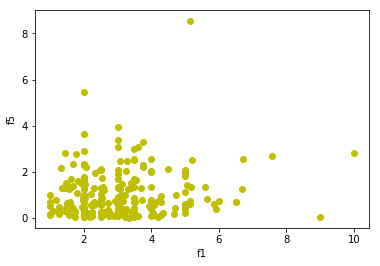

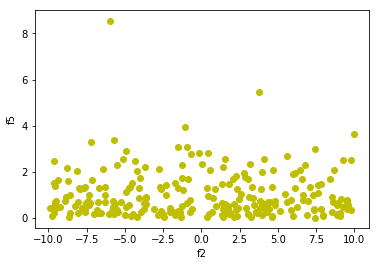

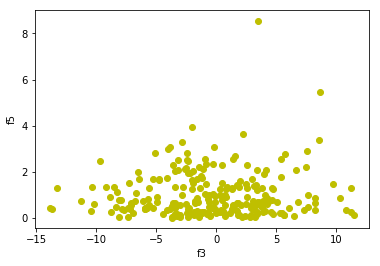

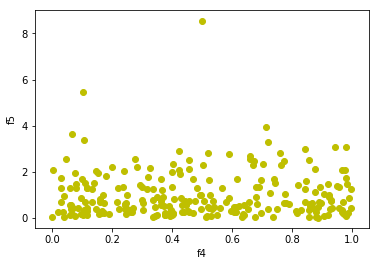

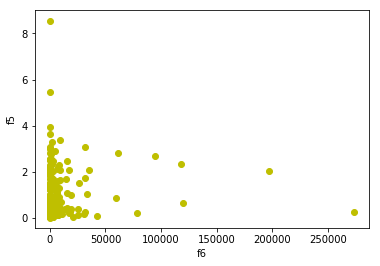

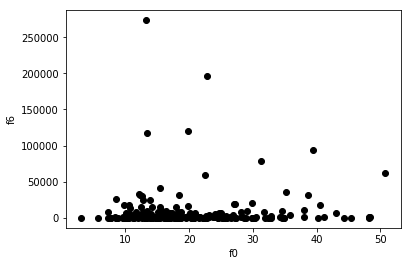

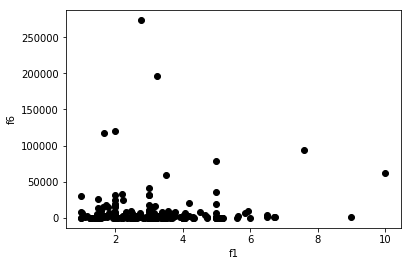

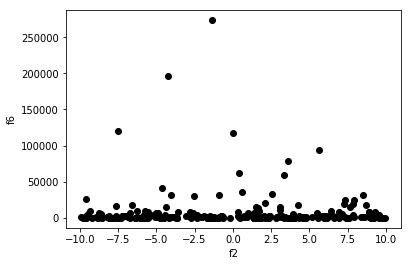

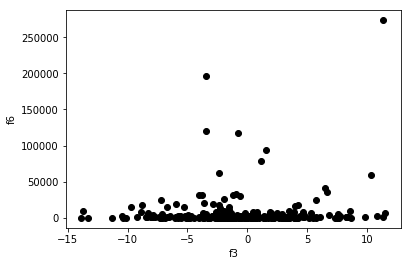

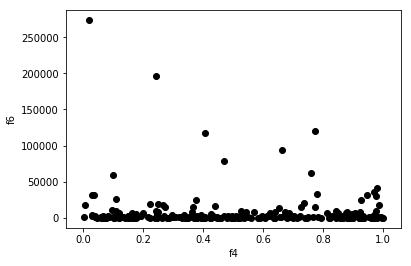

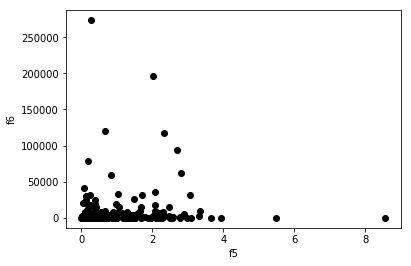

In [14]:
colours = ['b', 'g', 'r', 'c', 'm', 'y', 'k']

for i, t in enumerate(df.columns):
    pairplot(df, t, colours[i])

Был занулен признак f6. Из графика f1 и f6 не зависят друг от друга, поэтому линейная регрессия указала низкий вес для f6, а лассо занулила его.

## Реализация градиентного спуска

#### 5. Реализуйте модель линейной регрессии для функции потерь Huber loss, обучаемую градиентным спуском:

$$
L_\delta(a,y)=
\begin{cases}
 \frac{1}{2}(\hat{y} - y)^2,                   & |\hat{y} - y| \le \delta, \\
 \delta\, |\hat{y} - y| - \frac{1}{2}\delta^2 & \textrm{иначе.}
\end{cases}
$$

Все вычисления должны быть векторизованы, циклы средствами python допускается использовать только для итераций градиентного спуска. В качестве критерия останова необходимо использовать (одновременно):

* проверку на евклидовую норму разности весов на двух соседних итерациях (например, меньше некоторого малого числа порядка $10^{-6}$, задаваемого параметром `tolerance`);
* достижение максимального числа итераций (например, 10000, задаваемого параметром `max_iter`).

Необходимо реализовать метод полного и стохастического градиентных спусков, а также поддержать метод инерции (SGD with momentum - см.лекцию) при помощи параметра `alpha` (способ оценивания градиента должен задаваться при помощи параметра `gd_type`).

Чтобы проследить, что оптимизационный процесс действительно сходится, будем использовать атрибут класса `loss_history` — в нём после вызова метода `fit` должны содержаться значения функции потерь для всех предшествующих итераций.

Инициализировать веса можно случайным образом или нулевым вектором. Ниже приведён шаблон класса, который должен содержать код реализации модели.

In [15]:
from scipy.spatial import distance

In [16]:
from sklearn.base import BaseEstimator

class HuberReg(BaseEstimator):
    def __init__(self, delta=1.0, gd_type='stochastic', 
                 tolerance=1e-4, max_iter=1000, w0=None, alpha=0.9, eta=1e-2,
                stochastic_samples=20):
        """
        gd_type: 'full' or 'stochastic'
        tolerance: for stopping gradient descent
        max_iter: maximum number of steps in gradient descent
        w0: np.array of shape (D) - init weights
        eta: learning rate
        alpha: momentum coefficient
        """
        self.delta = delta
        self.gd_type = gd_type
        self.tolerance = tolerance
        self.max_iter = max_iter
        self.w0 = w0
        self.alpha = alpha
        self.w = None
        self.eta = eta
        self.loss_history = None
        self.stochastic_samples = stochastic_samples

    def fit(self, X, y):
        """
        X: np.array of shape (K, D)
        y: np.array of shape (K)
        ---
        output: self
        """
        self.loss_history = []
        y = np.array(y)
        b = np.ones((X.shape[0], 1))
        X = np.concatenate((X, b), axis=1)
        
        if self.w0 is None:
            self.w0 = np.random.rand(X.shape[1])

        self.w = np.copy(self.w0)
        
        last = None
        last_grad = np.zeros_like(self.w)
        
        for i in range(self.max_iter):
            last = np.copy(self.w)
            
            if self.gd_type == 'full':
                grad = self.calc_gradient(X, y)
                self.w -= self.eta * grad
            else:
                idx = np.random.choice(X.shape[0], self.stochastic_samples)
                grad = self.calc_gradient(X[idx], y[idx])
#                 if last_grad is not None:
                grad = self.alpha * last_grad - (1 - self.alpha) * grad
                last_grad = grad
                self.w += self.eta * grad            
            
            loss = self.calc_loss(X, y)
            self.loss_history.append(loss)
            
            dist = distance.euclidean(self.w, last)

            if dist < self.tolerance:
                break

        return self
    
    def predict(self, X):
        if self.w is None:
            raise Exception('Not trained yet')
            
        b = np.ones((X.shape[0], 1))
        X = np.concatenate((X, b), axis=1)
        
        return np.dot(X, self.w)
    
    def calc_gradient(self, X, y):
        """
        X: np.array of shape (K, D) (K can be equal to 1 if stochastic)
        y: np.array of shape (K)
        ---
        output: np.array of shape (D)
        """
        preds = np.dot(X, self.w)
        criterion = (preds - y).reshape(-1)
        
        mask = np.abs(criterion) <= self.delta
        y_mse = np.where(mask, criterion, np.zeros_like(criterion))
        y_mae = np.where(mask, np.zeros_like(criterion), criterion)

        y_mae_ones = np.where(y_mae > 0, np.ones_like(y_mae), np.zeros_like(y_mae))
        y_mae_ones = np.where(y_mae < 0, -1*np.ones_like(y_mae), y_mae_ones)

        mse_grad = X.T.dot(y_mse)

        mae_grad = self.delta*X.T.dot(y_mae_ones)

        return (mse_grad + mae_grad)/X.shape[0]

    def calc_loss(self, X, y):
        """
        X: np.array of shape (K, D)
        y: np.array of shape (K)
        ---
        output: float 
        """
        criterion = y - np.dot(X, self.w)
        mse = 0.5*criterion**2
        mae = self.delta*np.abs(criterion) - 0.5 * self.delta**2
        
        loss = np.where(np.abs(criterion) <= self.delta, mse, mae)
        
        return np.mean(loss)

#### 6. Обучите и провалидируйте модель на тех же данных, сравните качество с предыдущими методами. Исследуйте влияние параметров `max_iter` и `alpha` на процесс оптимизации. Согласуется ли оно с вашими ожиданиями?

In [17]:
hub_reg = HuberReg(max_iter=1000, gd_type='stochastic')
hub_reg.fit(norm_x_train, Y_train)
preds = hub_reg.predict(norm_x_test)
r2_score(Y_test, preds)

0.3769243767878585

In [18]:
hub_reg = HuberReg(max_iter=1000, gd_type='full')
hub_reg.fit(norm_x_train, Y_train)
preds = hub_reg.predict(norm_x_test)
r2_score(Y_test, preds)

0.3800015027503385

Качество значительно улучшилось

In [19]:
def return_history(cls):
    cls.fit(norm_x_train, Y_train)
    return cls.loss_history

In [20]:
alphas = np.linspace(0.1, 0.9, 9)
max_iter = [100, 150, 300, 500, 1000, 5000]

In [21]:
scores_full = []
params_full = []
for it in max_iter:
    cls = HuberReg(max_iter=it, gd_type='full')
    cls.fit(norm_x_train, Y_train)
    preds = cls.predict(norm_x_test)
    score = r2_score(Y_test, preds)    
    scores_full.append(score)
    params_full.append(it)

In [22]:
best_it = params_full[np.argmax(scores_full)]
print(f'full gd, max_iter: {best_it} score: {np.max(scores_full)}')

full gd, max_iter: 1000 score: 0.3800167771384919


In [23]:
scores = []
params_it = []
params_alpha = []
params = []
scores_all = []

for alpha in alphas:
    scores.append([])
    for it in max_iter:
        cls = HuberReg(max_iter=it, alpha=alpha, gd_type='stochastic')
        cls.fit(norm_x_train, Y_train)
        preds = cls.predict(norm_x_test)
        score = r2_score(Y_test, preds)
        scores[-1].append(score)
        scores_all.append(score)
        params.append((alpha, it))
        params_it.append(it)
        params_alpha.append(alpha)

In [24]:
best_a, best_it = params[np.argmax(scores_all)]
print(f'SGD, max_iter: {best_it}, alpha: {best_a} score: {np.max(scores)}')

SGD, max_iter: 1000, alpha: 0.4 score: 0.38715717271645966


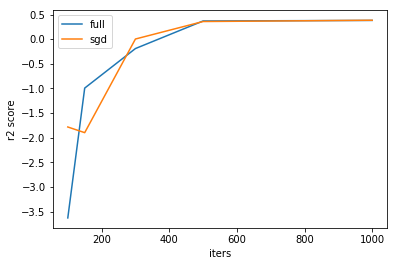

In [25]:
alpha_pos = 5
sgd_scores_best = scores[alpha_pos]
n = 5
plt.plot(params_full[:n], scores_full[:n], label='full')
plt.plot(params_it[:n], sgd_scores_best[:n], label='sgd')
plt.legend()
plt.xlabel('iters')
plt.ylabel('r2 score')
plt.show()

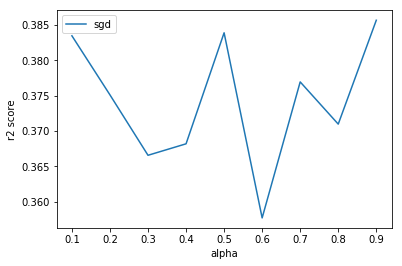

In [26]:
sgd_scores_best = scores[alpha_pos]
plt.plot(alphas, np.array(scores)[:,3], label='sgd')
plt.legend()
plt.xlabel('alpha')
plt.ylabel('r2 score')
plt.show()

С увеличением итераций скор увеличивается, пока не достигнет максимума. При фиксированном количестве итераций нельзя сказать, как скор зависит от альфа. 

#### 7. Постройте графики (на одной и той же картинке) зависимости величины функции потерь от номера итерации для полного, стохастического градиентного спусков, а также для полного градиентного спуска с методом инерции (SGD with momentum - см.лекцию). Сделайте выводы о скорости сходимости различных модификаций градиентного спуска.

Не забывайте о том, что должны из себя представлять *красивые* графики!

In [27]:
cls_full = HuberReg(max_iter=500, gd_type='full')
cls_sgd = HuberReg(max_iter=500, alpha=0.0)
cls_alpha = HuberReg(max_iter=500, alpha=0.3)

full = return_history(cls_full)
alpha = return_history(cls_alpha)
sgd = return_history(cls_sgd)

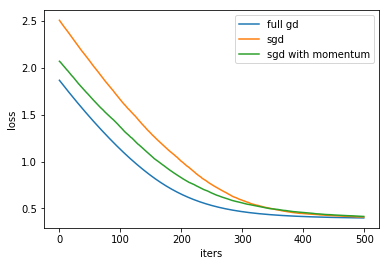

In [28]:
plt.plot(full, label='full gd')
plt.plot(sgd, label='sgd')
plt.plot(alpha, label='sgd with momentum')
plt.xlabel('iters')
plt.ylabel('loss')
plt.legend()
plt.show()

Быстрее всего сходится full gd.